# Week 5: GAN

For this week's mini-project, you will participate in one of the Faggle competitions (Refer the NOTE below for detailed information on the expectations):

Mnet Painting Dataset (New)

Generative Dog Images Dataset (Old)

We will use this Kaggle competition to practice building and training generative deep learning models (mostly GAN). Kaggle introduces an evaluation metric called **MiFID (Memorization-informed Frechet Inception Distance) score** to evaluate the quality of generated images. 

**Note**: This assignment has recently been updated to use Kaggle's GAN getting started competition, which is about changing styles of photos to Monet's painting. If you're been working on the older version (Dog image generation) of this assignments, you may not be able to submit results via kaggle and get test scores from Kaggle as the dog image generation competition's submission has been disabled recently. If it's the case, please skip the deliverable 3. Unless you've spent significant time on the old version (Dog image generation), please use the new version of this assignment. 

In [7]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from PIL import Image
from time import time

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import random_normal, ones_like, zeros_like, mean
from keras.callbacks import LearningRateScheduler

## Step 1
**Brief description of the problem and data (5 pts)**

The dataset contains photos of different breeds of dogs. In this project, I will build a GAN model to generate new dog images.

The data has 20,582 dog images and 120 distinct breeds. 





## Step 2
**Exploratory data analysis (EDA) -- Inspect, Visualize and Clean the data**

The images don't only have dogs in them but also other objects such as humans, flowers, cans, etc. Due to hardware limitation, I will crop the images so they only contain dogs and no others objects for faster training. 

In [21]:
# Crop the images so they only contain dogs and no other objects
dog_imgs = os.listdir("./data/all-dogs/")
breeds_l = os.listdir("./data/Annotation/")

ind = 0
names_in_l = list()

# new list for holding all cropped images
cropped_imgs_l = np.zeros((25000, 64, 64, 3))

for breed in breeds_l:
    for dog in os.listdir("./data/Annotation/" + breed):
        try:
            cur_dog = Image.open("./data/all-dogs/" + dog + ".jpg")
        except:
            continue
        cur_tree = ET.parse("./data/Annotation/" + breed + "/" + dog)
        cur_root = cur_tree.getroot()
        objects_l = cur_root.findall("object")
        
        for obj in objects_l:
            bnd_box = obj.find('bndbox')
            x_min = int(bnd_box.find('xmin').text)
            y_min = int(bnd_box.find('ymin').text)
            x_max = int(bnd_box.find('xmax').text)
            y_max = int(bnd_box.find('ymax').text)
            
            w = np.min((x_max - x_min, y_max - y_min))
            cropped_img = cur_dog.crop((x_min, y_min, x_min+w, y_min+w))
            cropped_img = cropped_img.resize((64, 64), Image.ANTIALIAS)
            cropped_imgs_l[ind, :, :, :] = np.asarray(cropped_img)
            
            names_in_l.append(breed)
            ind += 1

In [23]:
# Shuffle dog pictures
shuf_ind = np.arange(ind)
np.random.shuffle(shuf_ind)
cropped_imgs_l = cropped_imgs_l[shuf_ind, :, :, :]
names_in_l = np.array(names_in_l)[shuf_ind]

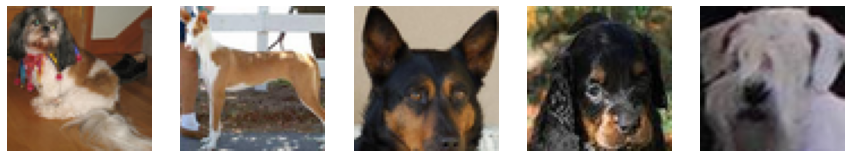

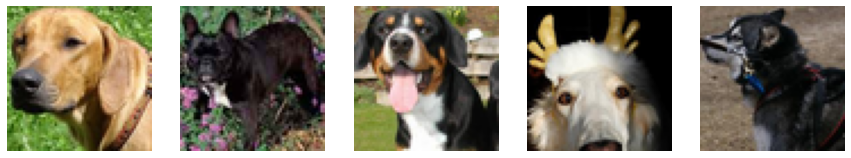

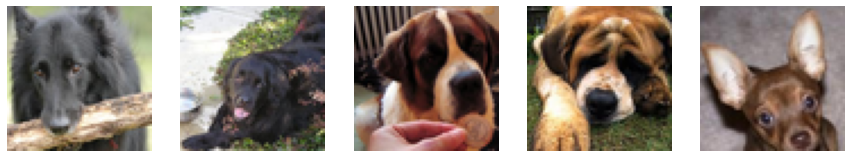

In [25]:
# Display some images
x = np.random.randint(0, ind, 30)
for i in range(3):
    plt.figure(figsize=(15, 3))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        cur_img = Image.fromarray(cropped_imgs_l[x[i * 5 + j], :, :, :].astype('uint8'))
        plt.axis('off')
        plt.imshow(cur_img)
    plt.show()

## Step 3
**Model Architecture**

A GAN consists 2 parts: discriminator and generator. The disciminator is a supervised neural network to classify the data point is "real" or "fake". The generator is a neural network that generates fake data to feed into the discriminator. 

In [28]:
# Build discriminator
num_pix = 12288
input_1 = Input((num_pix, ))
noise_size = 10000
input_2 = Input((noise_size, ))
batch_size = 64
buffer = 10000

discriminator = Dense(num_pix, activation='sigmoid')(input_2)
concat = concatenate([input_1, discriminator])
discriminator = Reshape((2, num_pix, 1))(concat)
discriminator = Conv2D(filters=1, kernel_size=[2,1], use_bias=False, name='conv')(discriminator)
discriminator = Flatten()(discriminator)

discriminator_model = Model([input_1, input_2], discriminator)

discriminator_model.get_layer("conv").trainable = False

initial_dis_weights_l = np.array([[[[-1.0]]], [[[1.0]]]])
discriminator_model.get_layer("conv").set_weights([initial_dis_weights_l])

print(discriminator_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 12288)]      0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 12288)        122892288   ['input_6[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 24576)        0           ['input_5[0][0]',                
                                                                  'dense_2[0][0]']          

In [29]:
# Compoile discriminator
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.5,
                                                             decay_steps=10000, decay_rate=0.9)

discriminator_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                            loss="binary_crossentropy")

# Train the discriminator
n = 10000
train_noise = np.zeros((n, n))
for i in range(n):
    train_noise[i, i] = 1
zeros_l = np.zeros((n, num_pix))

train_imgs_l = (cropped_imgs_l[:n, :, :, :]/255.).reshape((-1, num_pix))

callbacks_l = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')]

discriminator_history = discriminator_model.fit([zeros_l, train_noise], train_imgs_l,
                                                epochs=100, batch_size=batch_size, 
                                                callbacks=callbacks_l, verbose=0)

Text(0.5, 1.0, 'Discriminator Loss over Epochs')

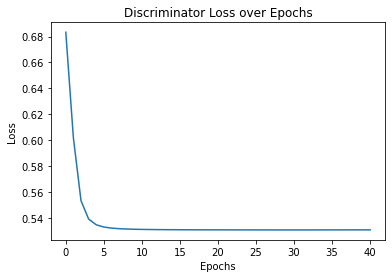

In [30]:
loss_l = discriminator_history.history["loss"]
epochs_l = [i for i in range(len(loss_l))]

plt.plot(epochs_l, loss_l)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Loss over Epochs")

In [31]:
# Build the generator
seed = Input((n, ))
generator = Dense(2048, activation='elu')(seed)
generator = Reshape((8, 8, 32))(generator)
generator = Conv2D(128, (3, 3), activation='elu', padding='same')(generator)
generator = UpSampling2D((2, 2))(generator)
generator = Conv2D(64, (3, 3), activation='elu', padding='same')(generator)
generator = UpSampling2D((2, 2))(generator)
generator = Conv2D(32, (3, 3), activation='elu', padding='same')(generator)
generator = UpSampling2D((2, 2))(generator)
generator = Conv2D(3, (3, 3), activation='linear', padding='same')(generator)
generator = Flatten()(generator)

reshaped_output = Reshape((n, ))(seed)

# Compile generator
generator_model = Model(seed, [generator, reshaped_output])
print(generator_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 2048)         20482048    ['input_7[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 8, 8, 32)     0           ['dense_3[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 128)    36992       ['reshape_2[0][0]']              
                                                                                            

In [39]:
discriminator_model.trainable = False
GAN_input = Input(shape=(n, ))
generator_output = generator_model(GAN_input)
GAN_output = discriminator_model(generator_output)

# compile GAN
GAN_model = Model(GAN_input, GAN_output)
initial_GAN_weights_l = np.array([[[[-1]]], [[[255.]]]])
GAN_model.get_layer("model_1").get_layer("conv").set_weights([initial_GAN_weights_l])

GAN_model.compile(optimizer="Adam", loss="mean_squared_error")

GAN_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10000)]      0           []                               
                                                                                                  
 model_2 (Functional)           [(None, 12288),      20612163    ['input_13[0][0]']               
                                 (None, 10000)]                                                   
                                                                                                  
 model_1 (Functional)           (None, 12288)        122892290   ['model_2[4][0]',                
                                                                  'model_2[4][1]']                
                                                                                            

Epoch 1 /0-loss = 0.22725966572761536
1/1 [==============================] - 0s 17ms/step


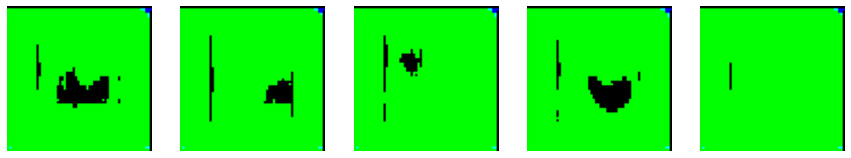

Epoch 2 /1-loss = 0.1695382297039032
1/1 [==============================] - 0s 28ms/step


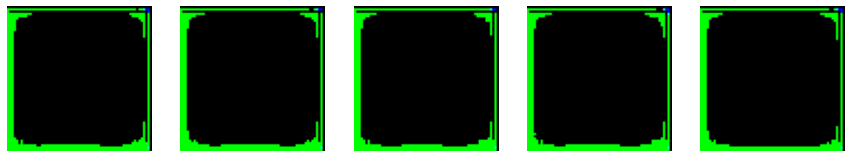

Epoch 3 /2-loss = 0.14004722237586975
1/1 [==============================] - 0s 17ms/step


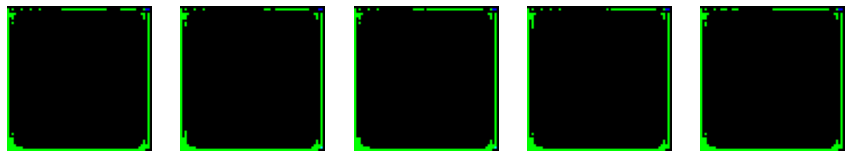

Epoch 4 /3-loss = 0.11834659427404404
1/1 [==============================] - 0s 23ms/step


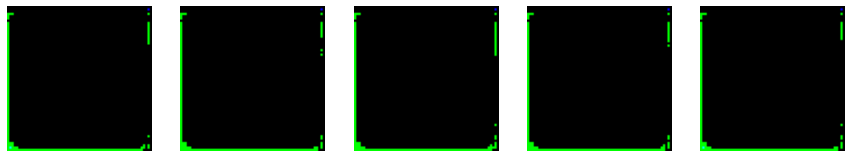

Epoch 5 /4-loss = 0.08265259116888046
1/1 [==============================] - 0s 17ms/step


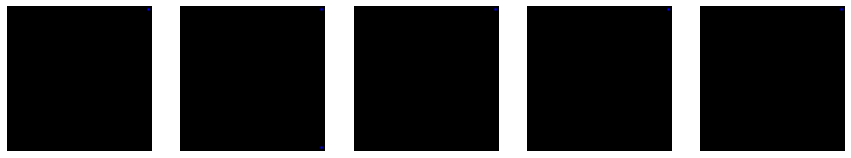

Epoch 6 /5-loss = 0.05547349154949188
1/1 [==============================] - 0s 17ms/step


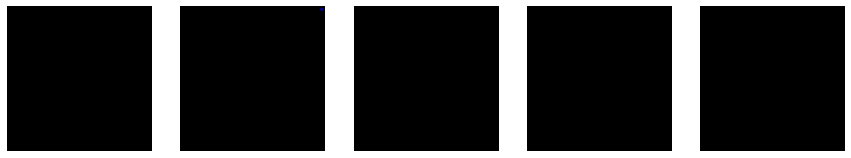

Epoch 7 /6-loss = 0.005330211948603392
1/1 [==============================] - 0s 18ms/step


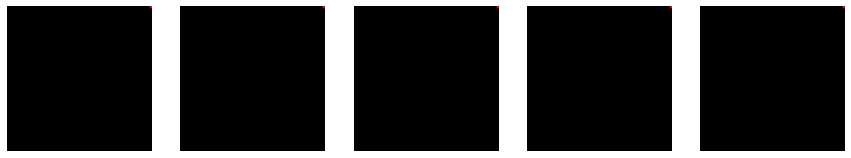

In [ ]:
#Training data
train_noise = np.ones((n, n))
zeros_l = np.zeros((n, num_pix))

# Train GAN
epochs = 1
num_iter = 15
eta = 0.005

for i in range(num_iter):
    model = GAN_model.fit(train_noise, zeros_l, epochs=epochs, 
                         batch_size=256, callbacks=[LearningRateScheduler(lambda x: eta)],
                         verbose=0)
    
    print('Epoch', (i+1), '/' + str(i) + '-loss =', model.history['loss'][-1])
    plt.figure(figsize=(15, 3))
    
    for j in range(5):
        sec_zeros_l = np.zeros((10000))
        sec_zeros_l[np.random.randint(10000)] = 1
        plt.subplot(1, 5, j+1)
        cur_img = generator_model.predict(sec_zeros_l.reshape((-1, 10000)))[0].reshape((-1, 64, 64, 3))
        cur_img = Image.fromarray((cur_img).astype('uint8').reshape((64, 64, 3)))
        plt.axis('off')
        plt.imshow(cur_img)
        
    plt.show()
    
    epochs *= 2
    if epochs >= 32: 
        eta = 0.001
    if epochs > 256:
        epochs = 256

## Step 4
**Results and Anlaysis**

I have trained the generator to make dog images. The generator, however, doesn't know about the breeds, it learns the common features of dogs. The model can be overfit. Following are some visualization and analysis.

In [ ]:
MSE_l = [6605, 2476, 1271, 703, 454, 311, 219, 150, 108, 92, 83, 78]
epochs = [i for i in range(1, len(MSE_l) + 1)]
plt.plot(epochs_l, MSE_l)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE vs. Epochs")
plt.show()

## Step 5
**Conclusion**

In this project, I do the following
1. Import and clean data
2. Do EDA
3. Build generator and discriminator for GAN model
4. Train GAN model

I learn a lot about how to build a GAN model thanks to available notebooks on Kaggle. Next time, I will run the training on GPU to see if it helps improve the performance.

**References:**
1. https://www.kaggle.com/code/paulorzp/show-annotations-and-breeds/notebook
2. https://www.kaggle.com/code/roydatascience/introduction-to-generative-adversarial-networks